# Import Libraries 

In [99]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import multiprocessing as mp


## Define functions

In [100]:
class quaternion:
    val = np.array([1,1,1,1])
    def __init__(self,a,b,c,d):
        self.val = np.array([a,b,c,d])
    def mult(self, q2):
        a1,b1,c1,d1 = self.val
        a2,b2,c2,d2 = q2.val
        q3 = quaternion(
            a1*a2-b1*b2-c1*c2-d1*d2,
            a1*b2+b1*a2+c1*d2-d1*c2,
            a1*c2-b1*d2+c1*a2+d1*b2,
            a1*d2+b1*c2-c1*b2+d1*a2
        )
        return q3
    def norm(self):
        a,b,c,d = self.val
        return np.sqrt(a**2+b**2+c**2+d**2)
    def conj(self):
        self.val = -self.val
        self.val[0] *= -1
        return self
    def add(self,q2):
        a1,b1,c1,d1 = self.val
        a2,b2,c2,d2 = q2.val
        q3 = quaternion(a1+a2,b1+b2,c1+c2,d1+d2)
        self = q3
        return self
    def sub(self,q2):
        a,b,c,d = self.val
        a2,b2,c2,d2 = q2.val
        vs = [a-a2,b-b2,c-c2,d-d2]
        #if any element is less than 0.0001 set it to 0     
        q3 = quaternion(vs[0],vs[1],vs[2],vs[3])
        return q3
    def abs_val(self):
        a,b,c,d = self.val
        out = a**2+b**2+c**2+d**2
        return out
    def inv(self):
        qc = self.conj()
        abs2 = self.abs_val()
        a,b,c,d = qc.val
        sc = abs2
        return quaternion(a/sc,b/sc,c/sc,d/sc)


In [123]:
def quaternion_subtraction(q1,q2):
    a,b,c,d = q1.val
    a2,b2,c2,d2 = q2.val
    q3 = quaternion(a-a2,b-b2,c-c2,d-d2)
    return q3

def print_q_mat(q_mat):
    out = []
    x,y = q_mat.shape
    for i in range(x):
        row = []
        for j in range(y):
            st = ""
            a,b,c,d = q_mat[i,j].val
            #round to 4 decimal places
            a = round(a,4)
            b = round(b,4)
            c = round(c,4)
            d = round(d,4)
            if a != 0:
                st += str(a)
            if b != 0:
                si = "+" if b > 0 else ""
                st += si+str(b)+"i"
            if c != 0:
                si = "+" if c > 0 else ""
                st += si+str(c)+"j"
            if d != 0:
                si = "+" if d > 0 else ""
                st += si+str(d)+"k"
            st = st.replace("+-","-")
            #replace the ' with """
            st = st.replace("'","")
            row.append(st)
        out.append(row)  
    print(np.array(out))

def split_into_real_matrices(A):
    x,y = A.shape
    out = [np.zeros(shape = (x,y)) for m in range(4)]
    for i in range(x):
        for l in range(y):
            a,b,c,d = A[i,l].val
            out[0][i,l] = a
            out[1][i,l] = b
            out[2][i,l] = c
            out[3][i,l] = d
    out = [np.array(a) for a in out]
    return out

def matrix_prod(A,B):
    A_s = split_into_real_matrices(A)
    B_s = split_into_real_matrices(B)
    a1,b1,c1,d1 = A_s
    a2,b2,c2,d2 = B_s


    ABr = a1@a2-b1@b2-c1@c2-d1@d2
    ABi = a1@b2+b1@a2+c1@d2-d1@c2
    ABj = a1@c2-b1@d2+c1@a2+d1@b2
    ABk = a1@d2+b1@c2-c1@b2+d1@a2

    x,y = A.shape[0],B.shape[1]
    out = generate_quaternion_matrix_nm(x,y)
    for i in range(x):
        for l in range(y):
            a,b,c,d = ABr[i,l],ABi[i,l],ABj[i,l],ABk[i,l]
            out[i,l] = quaternion(a,b,c,d)
    return out

def quaternion_matrix(n):
    arr = np.zeros((n,n),dtype=quaternion)
    for i in range(n):
        for j in range(n):
            arr[i,j] = quaternion(0,0,0,0)
    return arr

def quaternion_matrix_nm(n,m):
    arr = np.zeros((n,m),dtype=quaternion)
    for i in range(n):
        for j in range(m):
            arr[i,j] = quaternion(0,0,0,0)
    return arr

def find_quaternion_element(q):
    a,b,c,d = q.val
    temp = quaternion(0,0,c,d)
    minus_j = quaternion(0,0,-1,0)
    return temp.mult(minus_j)

def split_into_complex(q):
    A_real = []
    B_comp = []
    shape = q.shape
    for x in range(shape[0]):
        row_r = []
        row_c = []
        for y in range(shape[1]):
            
            a,b,c,d = q[x,y].val
            row_r.append(a+1j*b)
            
            temp = find_quaternion_element(q[x,y])
            a1,b1,c1,d1 = temp.val
            row_c.append(a1+1j*b1)
        A_real.append(row_r)
        B_comp.append(row_c)
        
    return np.array(A_real),np.array(B_comp)

def find_Qc(A):
    A_real,B_comp = split_into_complex(A)
    A_real_bar = np.conj(A_real)
    B_comp_bar = -np.conj(B_comp)
    C = np.concatenate((A_real,B_comp_bar),axis=0)
    D = np.concatenate((B_comp,A_real_bar),axis=0)
    out = np.concatenate((C,D),axis=1)
    return out

def SVD(A_q):
    A = find_Qc(A_q)
    U,s,Vh = np.linalg.svd(A)
    # V = np.conj(Vh.T)
    return U,s,Vh

def find_S(A_q):
    U,s,Vh = SVD(A_q)
    #take the unique elements of s
    unique_s = np.unique(s)
    x,y = U.shape[0],Vh.shape[1]
    x,y = int(x/2),int(y/2)
    S = quaternion_matrix_nm(x,y)
    for i in range(min(x,y)*2):
        if i % 2 == 0:
            S[int(i/2),int(i/2)] = quaternion(s[i],0,0,0)
    return S

def quaternion_norm(q):
    a,b,c,d = q.val
    return np.sqrt(a**2+b**2+c**2+d**2)

def quaternion_matrix_norm(A):
    x,y = A.shape
    nor = 0
    for i in range(x):
        for j in range(y):
            nor += quaternion_norm(A[i,j])**2
    return np.sqrt(nor)

def norm_diff(A,B):
    nor = 0
    x,y = A.shape
    for i in range(x):
        for j in range(y):
            asb = quaternion_subtraction(A[i,j],B[i,j])
            nor += quaternion_norm(asb)**2
    return np.sqrt(nor) 

def matrix_add(A,B):
    x,y = A.shape
    C = quaternion_matrix_nm(x,y)
    for i in range(x):
        for j in range(y):
            C[i,j] = A[i,j].add(B[i,j])
    return C

def matrix_sub(A,B):
    x,y = A.shape
    C = quaternion_matrix_nm(x,y)
    for i in range(x):
        for j in range(y):
            C[i,j] = A[i,j].sub(B[i,j])
    return C

def matrix_multiply(A,B):
    x = A.shape[0]
    y = B.shape[1]
    C = quaternion_matrix_nm(x,y)
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[0]):
                temp = A[i,k].mult(B[k,j])
                C[i,j] = C[i,j].add(temp)
    return C


def matrix_2x2_multiply(A,B):
    C = quaternion_matrix(2)
    
    t00 = A[0,0].mult(B[0,0])#quaternion_operator([A[0,0],"*",B[0,0]])
    C[0,0] = (A[0,1].mult(B[1,0]))#quaternion_operator([A[0,1],"*",B[1,0],'+',t00])
    C[0,0] = C[0,0].add(t00)
    t01 = A[0,0].mult(B[0,1]) #quaternion_operator([A[0,0],"*",B[0,1]])
    C[0,1] = (A[0,1].mult(B[1,1]))#quaternion_operator([A[0,1],"*",B[1,1],'+',t01])
    C[0,1] = C[0,1].add(t01)
    t10 = A[1,0].mult(B[0,0])#quaternion_operator([A[1,0],"*",B[0,0]])
    C[1,0] = (A[1,1].mult(B[1,0]))
    C[1,0] = C[1,0].add(t10)
    t11 = A[1,0].mult(B[0,1])#quaternion_operator([A[1,0],"*",B[0,1]])
    C[1,1] = (A[1,1].mult(B[1,1]))
    C[1,1] = C[1,1].add(t11)
    return C

def find_Q_U(A_q):
    # U,s,Vh = SVD(A_q)
    U = A_q
    # print(U)
    A = U[:,::2][0:int(len(U)/2)]
    B = U[:,::2][int(len(U)/2):]
    A_total = A
    B_total = -np.conj(B)
    # print("A")
    # print(A_total)
    # print("B")
    # print(B_total)
    x,y = B_total.shape
    U = quaternion_matrix_nm(x,y)
    for i in range(B_total.shape[0]):
        for j in range(B_total.shape[1]):
            a,b = np.real(A_total[i,j]),np.imag(A_total[i,j])
            c,d = np.real(B_total[i,j]),np.imag(B_total[i,j])
            # print(a,b,c,d)
            U[i,j] = quaternion(a,b,c,d)
    return U
def find_Q_V(A_q):
    # U,s,Vh = SVD(A_q)
    U = A_q
    # print(U)
    A = U[:,::2][0:int(len(U)/2)]
    B = U[:,::2][int(len(U)/2):]
    A_total = A
    B_total = -np.conj(B)
    # print("A")
    # print(A_total)
    # print("B")
    # print(B_total)
    U = quaternion_matrix(B_total.shape[0])
    for i in range(B_total.shape[0]):
        for j in range(B_total.shape[1]):
            a,b = np.real(A_total[i,j]),np.imag(A_total[i,j])
            c,d = -np.real(B_total[i,j]),np.imag(B_total[i,j])
            # print(a,b,c,d)
            U[i,j] = quaternion(a,b,c,d)
    return U


def conjugate_transpose(A):
    x,y = A.shape
    out = quaternion_matrix_nm(x,y)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a,b,c,d = A[i,j].val
            out[j,i] = quaternion(a,-b,-c,-d)
    return out  

def find_S_reciprocal(s):
    x,y = s.shape
    out = quaternion_matrix_nm(y,x)
    for i in range(min(x,y)):
        a = s[i,i].val[0]
        if a == 0:
            out[i,i] = quaternion(0,0,0,0)
        else:
            out[i,i] = quaternion(1/a,0,0,0)
    return out

def perturb_q_mat(A,sigma=0.001,alpha=0.001,isreal=False):
    x,y = A.shape
    B = np.zeros((x,y),dtype=quaternion)
    for i in range(x):
        for j in range(y):
            a,b,c,d = A[i,j].val
            n1,n2,n3,n4 = np.random.normal(0,sigma,4)
            if isreal:
                n2,n3,n4 = 0,0,0
            B[i,j] = quaternion(a*alpha+n1,b*alpha+n2,c*alpha+n3,d*alpha+n4)
    return B

# def perturb_q_mat(A,sigma=0.001,alpha=0.001,isreal=False):
#     x,y = A.shape
#     for i in range(x):
#         for j in range(y):
#             a,b,c,d = A[i,j].val
#             n1,n2,n3,n4 = np.random.normal(0,sigma,4)
#             if isreal:
#                 n2,n3,n4 = 0,0,0
#             A[i,j] = quaternion(a*alpha+n1,b*alpha+n2,c*alpha+n3,d*alpha+n4)
#     return A

def generate_quaternion_matrix(n,scalar=1):
    out = quaternion_matrix(n)
    for i in range(n):
        for j in range(n):
            a = random.uniform(-1,1)*scalar
            b = random.uniform(-1,1)*scalar
            c = random.uniform(-1,1)*scalar
            d = random.uniform(-1,1)*scalar
            out[i,j] = quaternion(a,b,c,d)
    return out

def generate_quaternion_matrix_nm(n,m,scalar=1,isreal=False):
    out = quaternion_matrix_nm(n,m)
    for i in range(n):
        for j in range(m):
            a = random.uniform(-1,1)*scalar
            b = random.uniform(-1,1)*scalar
            c = random.uniform(-1,1)*scalar
            d = random.uniform(-1,1)*scalar
            if isreal:
                b,c,d = 0,0,0
            out[i,j] = quaternion(a,b,c,d)
    return out

def generate_small_sparse_quaternion_matrix(n,m,scalar=0.001,sparsity=0.6,isreal=False):
    out = quaternion_matrix_nm(n,m)
    count = 0
    for i in range(n):
        for j in range(m):
            a = random.uniform(-1,1)*scalar
            b = random.uniform(-1,1)*scalar
            c = random.uniform(-1,1)*scalar
            d = random.uniform(-1,1)*scalar
            if isreal:
                b,c,d = 0,0,0
            if random.random() < sparsity:
                a,b,c,d = 0,0,0,0
                count += 1 
            out[i,j] = quaternion(a,b,c,d)
    if count < n*m*sparsity:
        out = generate_small_sparse_quaternion_matrix(n,m,scalar,sparsity,isreal)
    return out

def find_V(A_q):
    U,s,Vh = SVD(A_q)
    # print(U)
    column1 = Vh[:,0]
    column3 = Vh[:,2]
    # print(column1)
    # print(column3)
    #first 2 elements of column1 concatenated with first 2 elements of column3
    A1 = column1[:2]
    A2 = column3[:2]
    A_total = np.concatenate((A1,A2),axis=0)
    A_total = A_total.reshape(2,2).T
    #B1 is the last 2 elements of column1 and B2 is the last 2 elements of column3
    B1 = column1[2:]
    B2 = column3[2:]
    B_total = np.concatenate((B1,B2),axis=0)
    B_total = B_total.reshape(2,2).T
    B_total = -np.conj(B_total)
    U = quaternion_matrix(B_total.shape[0])
    for i in range(B_total.shape[0]):
        for j in range(B_total.shape[1]):
            a,b = np.real(A_total[i,j]),np.real(A_total[i,j])
            c,d = np.real(B_total[i,j]),np.real(B_total[i,j])
            U[i,j] = quaternion(a,b,c,d)
    return U

def Quaternionic_SVD(A_q):
    U,s,V = SVD(A_q)
    U_q = find_Q_U(U)
    V_q = find_Q_U(V)
    S = find_S(A_q)
    V_qstar = conjugate_transpose(V_q)
    return U_q,S,V_qstar

def Quaternionic_P_inverse(A):
    U,s,Vs = SVD_gen(A)
    S_inv = find_S_reciprocal(s)
    U_star = conjugate_transpose(U)
    V = conjugate_transpose(Vs)
    out = matrix_multiply(V,S_inv)
    out = matrix_multiply(out,U_star)
    return out

def SVD_gen(A):
    U,s,V = SVD(A)
    S = find_S(A)
    U_q = find_Q_U(U)
    
    V_q = find_Q_U(np.conj(V).T)
    V_qstar = conjugate_transpose(V_q)
    return U_q,S,V_qstar

def q_inv_gen(A):
    U,s,Vs = SVD_gen(A)
    S_inv = find_S_reciprocal(s)
    U_star = conjugate_transpose(U)
    V = conjugate_transpose(Vs)
    out = matrix_prod(V,S_inv)
    out = matrix_prod(out,U_star)
    return out

def SVD_and_Pseudo_Sizenm(n,m,scalar=1):
    A = generate_quaternion_matrix_nm(n,m,scalar)
    U,s,Vs = SVD_gen(A)
    A_inv = q_inv_gen(A)
    AAi = matrix_prod(A,A_inv)
    AiA = matrix_prod(A_inv,A)
    print("Finding the SVD and subsequent Pseudo-Inverse of the following matrix A:")
    print("Size of A:")
    print("(", n, ",", m, ")")
    print("A=")
    print_q_mat(A)
    print("U=")
    print_q_mat(U)
    print("s=")
    print_q_mat(s)
    print("V=")
    print_q_mat(conjugate_transpose(Vs))
    print("V*=")
    print_q_mat(Vs)
    print("U*=")
    print_q_mat(conjugate_transpose(U))
    print("Pseudo-Inverse:")
    print_q_mat(A_inv)
    print("Multiplication by Pseudo-Inverse on the Right:")
    print_q_mat(AAi)
    print("Multiplication by Pseudo-Inverse on the Left:")
    print_q_mat(AiA)

def SVD_and_Pseudo_SizeRandom(k,l,scalar=1):
    n = np.random.randint(k,l)
    m = np.random.randint(k,l)
    A = generate_quaternion_matrix_nm(n,m,scalar)
    U,s,Vs = SVD_gen(A)
    A_inv = q_inv_gen(A)
    AAi = matrix_prod(A,A_inv)
    AiA = matrix_prod(A_inv,A)
    print("Finding the SVD and subsequent Pseudo-Inverse of the following matrix A:")
    print("Size of A:")
    print("(", n, ",", m, ")")
    print("A=")
    print_q_mat(A)
    print("U=")
    print_q_mat(U)
    print("s=")
    print_q_mat(s)
    print("V=")
    print_q_mat(conjugate_transpose(Vs))
    print("V*=")
    print_q_mat(Vs)
    print("U*=")
    print_q_mat(conjugate_transpose(U))
    print("Pseudo-Inverse:")
    print_q_mat(A_inv)
    print("Multiplication by Pseudo-Inverse on the Right:")
    print_q_mat(AAi)
    print("Multiplication by Pseudo-Inverse on the Left:")
    print_q_mat(AiA)

def SVD_and_Pseudo_Square(n,scalar=1):
    A = generate_quaternion_matrix(n,scalar)
    U,s,Vs = SVD_gen(A)
    A_inv = q_inv_gen(A)
    AAi = matrix_prod(A,A_inv)
    AiA = matrix_prod(A_inv,A)
    print("Finding the SVD and subsequent Pseudo-Inverse of the following matrix A:")
    print("Size of A:")
    print("(", n, ",", n, ")")
    print("A=")
    print_q_mat(A)
    print("U=")
    print_q_mat(U)
    print("s=")
    print_q_mat(s)
    print("V=")
    print_q_mat(conjugate_transpose(Vs))
    print("V*=")
    print_q_mat(Vs)
    print("U*=")
    print_q_mat(conjugate_transpose(U))
    print("Pseudo-Inverse:")
    print_q_mat(A_inv)
    print("Multiplication by Pseudo-Inverse on the Right:")
    print_q_mat(AAi)
    print("Multiplication by Pseudo-Inverse on the Left:")
    print_q_mat(AiA)

def SVD_and_Pseudo_A(A):
    U,s,Vs = SVD_gen(A)
    A_inv = q_inv_gen(A)
    AAi = matrix_prod(A,A_inv)
    AiA = matrix_prod(A_inv,A)
    Us= matrix_prod(U,s)
    UsV = matrix_prod(Us,Vs)
    print("Finding the SVD and subsequent Pseudo-Inverse of the following matrix A:")
    print("Size of A:")
    print(np.shape(A))
    print("A=")
    print_q_mat(A)
    print("U=")
    print_q_mat(U)
    print("s=")
    print_q_mat(s)
    print("s^-1=")
    print_q_mat(find_S_reciprocal(s))
    print("V=")
    print_q_mat(conjugate_transpose(Vs))
    print("V*=")
    print_q_mat(Vs)
    print("U*=")
    print_q_mat(conjugate_transpose(U))
    print("UsV*=")
    print_q_mat(UsV)
    print("Pseudo-Inverse:")
    print_q_mat(A_inv)
    print("Multiplication by Pseudo-Inverse on the Right:")
    print_q_mat(AAi)
    print("Multiplication by Pseudo-Inverse on the Left:")
    print_q_mat(AiA)

## Change into latex

In [8]:
def convert(matrix):
    #takes a string matrix in the form of how python prints it and converts it to latex code
    matrix = matrix.replace("[[", "\\begin{bmatrix}\n")
    matrix = matrix.replace("]]", "\n\\end{bmatrix}")
    matrix = matrix.replace("[", "")
    matrix = matrix.replace("]", "\\\\")
    matrix = matrix.replace(" ", " & ")
    matrix = matrix.replace(", ", " & ")
    #check if any line starts with & and remove it
    matrix = matrix.split("\n")
    for i in range(len(matrix)):
        if matrix[i].startswith(" & "):
            matrix[i] = matrix[i][3:]
    matrix = "\n".join(matrix)
    matrix = matrix.replace("''","0")
    matrix = matrix.replace("'","")
    return matrix

# Perturb

In [88]:
###Run scale perturbed test
def run_scaled_perturbed_test(n=10,alpha_0=-10,alpha_1=10,alpha_n=100):
    alpha = np.linspace(alpha_0,alpha_1,alpha_n)
    errors = []
    for i in tqdm(range(len(alpha))):
        e = 0
        for g in range(n):
            a= random.randint(2,10)
            b= random.randint(2,10)
            A = generate_quaternion_matrix_nm(a,b,10)
            A_inv = q_inv_gen(A)
            A_p = perturb_q_mat(A,sigma=0,alpha=alpha[i])
            A_p_inv = q_inv_gen(A_p)
            e += norm_diff(A_p_inv,A_inv)/n
        
        errors.append(e)
    return errors

In [89]:
###Run additive perturbed test
def run_additive_perturbed_test(n=10,sigma_0=0,sigma_1=1,sigma_n=1000,isreal=False):
    sigma = np.linspace(sigma_0,sigma_1,sigma_n)
    errors = []
    for i in tqdm(range(len(sigma))):
        e = 0
        for g in range(n):
            a= random.randint(2,10)
            b= random.randint(2,10)
            A = generate_quaternion_matrix_nm(a,b,10,isreal=isreal)
            A_inv = q_inv_gen(A)
            A_p = perturb_q_mat(A,sigma=sigma[i],alpha=1,isreal=isreal)
            A_p_inv = q_inv_gen(A_p)
            e += norm_diff(A_p_inv,A_inv)/n

        errors.append(e)
    return errors


In [90]:
###Run additive perturbed test sparse
def run_additive_perturbed_test_sparse(n=10,sigma_0=0,sigma_1=1,sigma_n=1000,isreal=False,sparsity=0.6,scalar=0.001):
    sigma = np.linspace(sigma_0,sigma_1,sigma_n)
    errors = []
    for i in tqdm(range(len(sigma))):
        e = 0
        for g in range(n):
            a= random.randint(2,10)
            b= random.randint(2,10)
            A = generate_small_sparse_quaternion_matrix(a,b,scalar,sparsity,isreal=isreal)
            A_inv = q_inv_gen(A)
            A_p = perturb_q_mat(A,sigma=sigma[i],alpha=1,isreal=isreal)
            A_p_inv = q_inv_gen(A_p)
            e += norm_diff(A_p_inv,A_inv)/n

        errors.append(e)
    return errors

In [91]:
###Run linear perturbed test
def run_linear_perturbed_test(n=10,sigma_0=0,sigma_1=1,sigma_n=1000,alpha_0=-10,alpha_1=10,alpha_n=1000):
    sigma = np.linspace(sigma_0,sigma_1,sigma_n)
    alpha = np.linspace(alpha_0,alpha_1,alpha_n)
    errors = []
    for i in tqdm(range(len(sigma))):
        err = []
        for g in range(len(alpha)):
            e = 0
            for k in range(n):
                a = random.randint(2,10)
                b = random.randint(2,10)
                A = generate_quaternion_matrix_nm(a,b,10)
                A_inv = q_inv_gen(A)
                A_p = perturb_q_mat(A,sigma=sigma[i],alpha=alpha[g])
                A_p_inv = q_inv_gen(A_p)
                e += norm_diff(A_p_inv,A_inv)/n
            err.append(e)
        errors.append(err)
    errors = np.array(errors)
    return errors

In [92]:
def plot_error(error,title,xlabel,ylabel,xticks,yticks,save=False,savetitle="",zlabel="",as_matrix = True,is_log = False):
    error = np.array(error)
    #check if error is 1d 
    if len(error.shape) == 1:
        plt.plot(error)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        #plt.ylim(-0.2,1)
        xticks = np.round(xticks,5)
        plt.xticks(np.linspace(0,len(error)-1,len(xticks)),xticks)
        if is_log:
            plt.yscale("log")
        # plt.xticks(npxticks)
        # plt.yticks(yticks)
        if save:
            plt.savefig("C:/Users/nicks/Desktop/latex/thesis/Images/"+savetitle+".jpg",dpi=300)
        plt.show()
    else:
        if not as_matrix:
            #do a 3d plot of errors
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #zoom out
            #set view point
            ax.view_init(30, -135)
            x,y = error.shape
            xs = np.linspace(0,x-1,x)
            ys = np.linspace(0,y-1,y)
            X,Y = np.meshgrid(xs,ys)
            ax.plot_surface(X,Y,error)
            plt.title(title)
            plt.xlabel(xlabel,fontsize=7)
            plt.ylabel(ylabel,fontsize=7)
            ax.set_zlabel(zlabel,fontsize=7)
            ax.set_xticks(np.linspace(0,len(xs)-1,len(xticks)),xticks)
            ax.set_yticks(np.linspace(0,len(ys)-1,len(yticks)),yticks)
            ax.set_box_aspect(aspect=None, zoom=0.8)
            if save:
                plt.savefig("C:/Users/nicks/Desktop/latex/thesis/Images/"+savetitle+".jpg",dpi=300, bbox_inches='tight')
            plt.show()
        else:
            x,y = error.shape

            plt.matshow(error)
            cb = plt.colorbar()
            cb.set_label(zlabel)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.xticks(np.linspace(0,x-1,len(xticks)),xticks)
            plt.yticks(np.linspace(0,y-1,len(yticks)),yticks)
            if save:
                plt.savefig("C:/Users/nicks/Desktop/latex/thesis/Images/"+savetitle+".jpg",dpi=300)
            plt.show()
            

In [93]:
random.seed(741011021021)
#random.seed(69420)

alpha_errors = run_scaled_perturbed_test(n=100,alpha_0=-10,alpha_1=10,alpha_n=1000)
#sigma_errors = run_additive_perturbed_test(n=100,sigma_0=0,sigma_1=5,sigma_n=1000,isreal=False)
#sigma_errors_real = run_additive_perturbed_test(n=100,sigma_0=0,sigma_1=5,sigma_n=1000,isreal=True)
#sigma_errors_real_less = run_additive_perturbed_test(n=100,sigma_0=0,sigma_1=5,sigma_n=100,isreal=True)
#sigma_errors_sparse = run_additive_perturbed_test_sparse(n=100,sigma_0=0,sigma_1=0.05,sigma_n=1000,isreal=False,sparsity=0.6,scalar=0.001)
#linear_errors = run_linear_perturbed_test(n=100,sigma_0=0,sigma_1=5,sigma_n=100,alpha_0=-10,alpha_1=10,alpha_n=100)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s]


In [159]:
random.seed(741011021021)
#random.seed(69420)
sizes = 0
sizes_inv = 0
avg_size_elements = 0
avg_size_elements_inv = 0
size_element_mat = []
size_element_mat_inv = []
for jeff in tqdm(range(100000)):
    rand_1 = random.randint(2,10)
    rand_2 = random.randint(2,10)
    Mat = generate_quaternion_matrix_nm(rand_1,rand_2,10,isreal=False)
    Mat_inv = q_inv_gen(Mat)
    for i in range(rand_1):
        for j in range(rand_2):
            size_elem = quaternion_norm(Mat[i,j])
            a,b,c,d = Mat[i,j].val
            size_element_mat += [a,b,c,d]
            avg_size_elements += size_elem/(rand_1*rand_2*100000)
            size_elem = quaternion_norm(Mat_inv[j,i])
            a,b,c,d = Mat_inv[j,i].val
            size_element_mat_inv += [a,b,c,d]
            avg_size_elements_inv += size_elem/(rand_1*rand_2*100000)
    sizes += quaternion_matrix_norm(Mat)/100000
    sizes_inv += quaternion_matrix_norm(Mat_inv)/100000
print(sizes)
print(sizes_inv)
print(avg_size_elements)
print(avg_size_elements_inv)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [06:09<00:00, 270.96it/s]

65.69223686035012
0.11761603043576106
11.220489100544878
0.020361578771121793


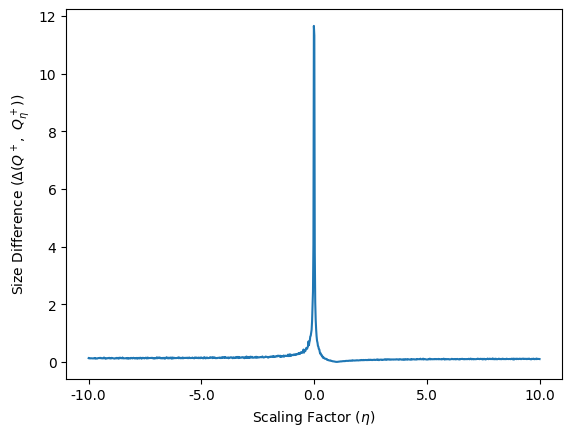

In [95]:
##Plotting the scaling factor error:
plot_error(alpha_errors,"",r'Scaling Factor ($\eta$)',r'Size Difference ($\Delta(Q^+, \ Q_\eta^+)$)',np.linspace(-10,10,5),np.linspace(0,1,1000),save=False,savetitle="Error_vs_Scaling_Factor_correct_ylim")

##Plotting the additive noise error:
#plot_error(sigma_errors,"",r'Standard Deviation ($\sigma$)',r'Size Difference ($\Delta(Q^+, \ Q_\varepsilon^+)$)',np.linspace(0,5,5),np.linspace(0,1,1000),save=True,savetitle="Error_vs_Standard_Deviation_correct")

##Plotting the additive noise error real:
#plot_error(sigma_errors_real,"",r'Standard Deviation ($\sigma$)',r'Size Difference ($\Delta(A^+, \ A_\omega^+)$)',np.linspace(0,5,5),np.linspace(0,1,1000),save=False,is_log=False,savetitle="Error_vs_Standard_Deviation_real_correct")
#plot_error(sigma_errors_real_less,"",r'Standard Deviation ($\sigma$)',r'Size Difference ($\Delta(A^+, \ A_\omega^+)$)',np.linspace(0,5,5),np.linspace(0,1,1000),save=False,is_log=False,savetitle="Error_vs_Standard_Deviation_real_correct_lessn")

##Plotting the additive noise error sparse:
#plot_error(sigma_errors_sparse,"",r'Standard Deviation ($\sigma$)',r'Size Difference ($\Delta(Q^+, \ Q_\varepsilon^+)$)',np.linspace(0,0.05,5),np.linspace(0,1,1000),save=True,savetitle="Error_vs_Standard_Deviation_Sparse_correct",zlabel=r'Size Difference ($\Delta(A^+, \ A_\omega^+)$',as_matrix=True,is_log=True)

##Plotting the linear error:
#plot_error(linear_errors,"",ylabel=r'Standard Deviation ($\sigma$)',xlabel=r'Scaling Factor ($\eta$)',xticks=np.linspace(-10,10,5),yticks=np.linspace(0,5,5),save=False,savetitle="Error_vs_Standard_Deviation_vs_Scaling_Factor_Colour_bigSD_ bign",zlabel=r'Size Difference ($\Delta(Q^+, \ Q_{\eta,\varepsilon}^+))$',as_matrix=True)
#plot_error(linear_errors,"",ylabel=r'Standard Deviation ($\sigma$)',xlabel=r'Scaling Factor ($\eta$)',xticks=np.linspace(-10,10,5),yticks=np.linspace(0,5,5),save=True,savetitle="Error_vs_Standard_Deviation_vs_Scaling_Factor_3D_bigSD_bign_angle1",zlabel=r'Size Difference ($\Delta(Q^+, \ Q_{\eta,\varepsilon}^+))$',as_matrix=False)


# Theoretical results Scaling Factor


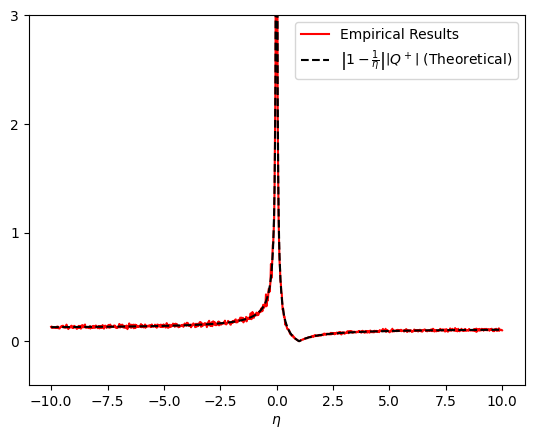

In [97]:
xs = np.linspace(-10,10,1000)
ys = (0.11761603043576106)*np.abs(1-1/xs)
plt.plot(xs,alpha_errors,label='Empirical Results', color='red')
plt.plot(xs,ys,label=r'$\left|1-\frac{1}{\eta}\right| \left|Q^+\right|$ (Theoretical)', linestyle ='dashed', color='black')
plt.ylim(-0.4,3)
plt.yticks([0,1,2,3])
plt.xlabel(r'$\eta$')
# plt.ylabel(r'$\left|1-\frac{1}{\eta}\right|$')
plt.legend()
savetitle = "Error_vs_Scaling_Factor_Comparison_correct"
plt.savefig("C:/Users/nicks/Desktop/latex/thesis/Images/"+savetitle+".jpg",dpi=300)

# Theoretical Results Additive Error

In [141]:
random.seed(69420)
np.random.seed(69420)

A = generate_quaternion_matrix_nm(2,3,10)
print("A=")
print_q_mat(A)

A_pert = perturb_q_mat(A,0.1,1,False)
print("A+B=")
print_q_mat(A_pert) 

B = matrix_sub(A_pert,A)
print("B=")
print_q_mat(B)

A_inv = q_inv_gen(A)
print("A^+=")
print_q_mat(A_inv)

A_pert_inv = q_inv_gen(A_pert)
print("(A+B)^+=")
print_q_mat(A_pert_inv)

B_A_inv = matrix_prod(B,A_inv)
print("B*A^+=")
print_q_mat(B_A_inv)

A_inv_B_A_inv = matrix_prod(A_inv,B_A_inv)
print("A^+*B*A^+=")
print_q_mat(A_inv_B_A_inv)

A_inv_minus_A_pert_inv = matrix_sub(A_inv,A_pert_inv)
print("A^+-(A+B)^+=")
print_q_mat(A_inv_minus_A_pert_inv)

quaternion_matrix_norm(A_inv_minus_A_pert_inv)
print("Norm of A^+-(A+B)^+=")
print(quaternion_matrix_norm(A_inv_minus_A_pert_inv))

quaternion_matrix_norm(A_inv_B_A_inv)
print("Norm of A^+*B*A^+")
print(quaternion_matrix_norm(A_inv_B_A_inv))

def additive_perturbation_theoretical(n=100,sigma_0=0,sigma_1=5,sigma_n=1000,isreal=False):
    sigma = np.linspace(sigma_0,sigma_1,sigma_n)
    errors = []
    for i in tqdm(range(len(sigma))):
        e = [0,0]
        for g in range(n):
            a = random.randint(2,10)
            b = random.randint(2,10)
            A = generate_quaternion_matrix_nm(a,b,10,isreal=isreal)
            A_inv = q_inv_gen(A)
            A_pert = perturb_q_mat(A,sigma[i],1,False)
            B = matrix_sub(A_pert,A)
            ApB_inv = q_inv_gen(A_pert)
            n1 = norm_diff(A_inv,ApB_inv)
            A_invB = matrix_prod(A_inv,B)
            A_invBA_inv = matrix_prod(A_invB,A_inv)
            n2 = quaternion_matrix_norm(A_invBA_inv)
            e[0] += n1
            e[1] += n2
        errors.append([e[0]/n,e[1]/n])
    return errors

A=
[['3.6399-3.6525i+2.0533j+7.5446k' '0.58-6.3429i+0.0809j+7.8697k'
  '-9.2478+1.5908i-3.0744j-0.8828k']
 ['-9.2528+6.516i-3.8761j-0.1491k' '9.722+4.257i-0.9474j+0.443k'
  '0.8815-6.5587i-7.0162j+2.7895k']]
A+B=
[['3.4234-3.6055i+1.8491j+7.5599k' '0.5487-6.3457i-0.1303j+7.8113k'
  '-9.2524+1.6203i-3.238j-0.7856k']
 ['-9.3068+6.3805i-3.8514j-0.0664k' '9.8121+4.2487i-0.9489j+0.4031k'
  '0.8354-6.5602i-7.0971j+2.5221k']]
B=
[['-0.2165+0.047i-0.2042j+0.0153k' '-0.0313-0.0028i-0.2112j-0.0585k'
  '-0.0047+0.0294i-0.1636j+0.0973k']
 ['-0.054-0.1355i+0.0248j+0.0827k' '0.0901-0.0083i-0.0015j-0.0399k'
  '-0.0461-0.0016i-0.0809j-0.2674k']]
A^+=
[['0.0049+0.0451i+0.028j-0.0333k' '-0.0594+0.0045i+0.0142j+0.0011k']
 ['0.0125+0.0117i-0.0236j-0.0301k' '0.0313+0.0126i-0.0069j+0.0038k']
 ['-0.0217-0.0035i+0.0311j+0.0009k' '-0.0149+0.0039i+0.0171j-0.0174k']]
(A+B)^+=
[['0.0048+0.0449i+0.0285j-0.0331k' '-0.0593+0.0042i+0.0133j+0.0013k']
 ['0.0111+0.012i-0.0228j-0.0299k' '0.031+0.0115i-0.0069j+0.0046k']
 

In [179]:
random.seed(694201)
np.random.seed(694201)

errors = additive_perturbation_theoretical(100,0,5,1000)
errors = np.array(errors).T

100%|██████████| 1000/1000 [10:48<00:00,  1.54it/s]


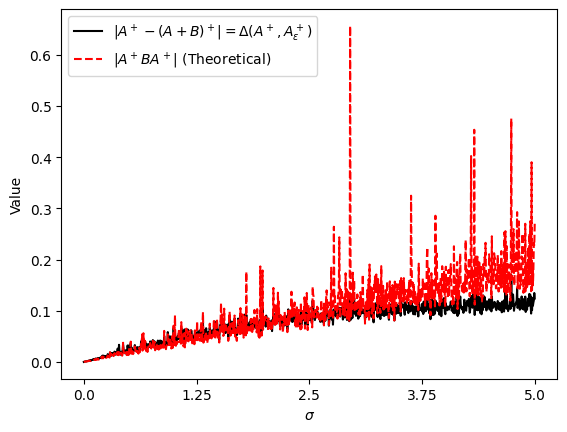

In [182]:
plt.plot(errors[0],label=r"$|A^+-(A+B)^+|=\Delta(A^+,A_{\varepsilon}^+)$",c='k')
plt.plot(errors[1],label=r"$|A^+BA^+|$ (Theoretical)",linestyle="dashed",c='r')
plt.legend()
plt.xticks(np.linspace(0,999,5),np.linspace(0,5,5))
plt.ylabel(r'Value')
plt.xlabel(r'$\sigma$')
savetitle = "additive_perturbation_theoretical_bigpoints.jpg"
#plt.savefig("C:/Users/nicks/Desktop/latex/thesis/Images/"+savetitle+".jpg",dpi=300)